In [1]:
# Don't use this or you can't visualise the data for some reason
#import findspark
#import streamlit
#findspark.init()

In [2]:
#Import pyspark
import pyspark
from pyspark import SparkContext, SparkConf
from collections import Counter
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import split, col

from pyspark.sql import SparkSession
#spark = SparkSession.builder.getOrCreate()
spark = SparkSession.builder.master('local[10]').config('spark.driver.memory','10g').getOrCreate()

conf = SparkConf().setAppName('Project').setMaster('local')
sparkContext = SparkContext.getOrCreate(conf=conf) #SparkContext(conf = conf)

/usr/local/lib/python3.12/site-packages/pyspark/bin/load-spark-env.sh: line 68: ps: command not found
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/12 13:51:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Read in and assign column names
# Income data
Income = spark.read.csv('income_csv_cleaned_no_commas.csv',header=False)
Income = Income.toDF('Area_code','Area','Self_num_ind','Self_mean','Self_median','Num_ind','Mean','Median','Pens_num_ind','Pens_mean',
                     'Pens_median','Other_num_ind','Other_mean','Other_median','Tot_num_ind','Tot_mean','Tot_median','Tax_num_ind','Tax_mean','Tax_median','Tot_tax')

# Drop not applicable
Income = Income.na.drop()
Income = Income.filter(Income.Area_code!='Not applicable')

# Remove original formatting
Income = Income.filter(Income.Area!='Region/County')

# Population data
Population = spark.read.csv('population_data.csv',header=False)
Population = Population.toDF('Code','Name','Geography','All_ages','0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15',
                     '16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31','32','33','34','35','36','37',
                     '38','39','40','41','42','43','44','45','46','47','48','49','50','51','52','53','54','55','56','57','58','59',
                     '60','61','62','63','64','65','66','67','68','69','70','71','72','73','74','75','76','77','78','79','80','81','82','83','84','85','86','87','88','89','90+')

# Drop not applicable
Population = Population.na.drop()

# Remove original formatting
Population = Population.filter(Population.Code!='Code')

# Income data
Statements = spark.read.csv('Transposed_Consolidated_Income_Statements.csv',header=False)
Statements = Statements.toDF('Company','Fina_period','State','Revenue','Cost','Gross','Other','Disp_close','Admin','Operating','Fin_out','Fin_in','Share_loss','Before_tax','Tax','Profit')

# Remove original formatting
Statements = Statements.drop(col('Company'))
Statements = Statements.drop(col('Fina_period'))
Statements = Statements.drop(col('State'))

# Remove original formatting
Statements = Statements.filter(Statements.Cost!='Cost of sales')

#Income.show()

In [4]:
Population.show()

25/03/12 13:51:57 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+---------+--------------------+--------------------+--------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+
|     Code|                Name|           Geography|All_ages|     0|     1|     2|     3|     4|     5|     6|     7|     8|     9|    10|    11|    12|    13|    14|    15|    16|    17|    18|    19|    20|    21|    22|    23|    24|    25|    26|    27|    28|    29|    30|    31|    32|    33|

In [5]:
#Statements.show()

In [6]:
import numpy as np
from pyspark.sql import functions as F
from pyspark.sql.functions import monotonically_increasing_id

# Condensing the data to only what is relevant
# Dropping self employement data

# Income condensed
Cond_Inc = Income

Cond_Inc = Cond_Inc.drop(col('Self_num_ind'))
Cond_Inc = Cond_Inc.drop(col('Self_mean'))
Cond_Inc = Cond_Inc.drop(col('Self_median'))

# Dropping pension data
Cond_Inc = Cond_Inc.drop(col('Pens_num_ind'))
Cond_Inc = Cond_Inc.drop(col('Pens_mean'))
Cond_Inc = Cond_Inc.drop(col('Pens_median'))

# Remove the non-applicable areas
Cond_Inc = Cond_Inc.filter(Cond_Inc.Area_code != 'Not applicable')

# Population condensed
Cond_Pop = Population

# Dropping columns for individual ages
for colu in range(0,90):
    Cond_Pop = Cond_Pop.drop('',col(str(colu)))

Cond_Pop = Cond_Pop.drop(col('90+'))

# Dropping repeated data in both population and income
Cond_Pop = Cond_Pop.drop(col('Geography'))
Cond_Pop = Cond_Pop.drop(col('Name'))

# Remove commas from numbers
#Cond_Pop = Cond_Pop.map(lambda x: str(x).replace(',', '') if isinstance(x, str) else x)

# Join two dataframes
Data = Cond_Pop.join(Cond_Inc,Cond_Inc.Area_code == Cond_Pop.Code,'inner')
Data = Data.drop(col('Area_code'))

# Add new primary key
Data = Data.withColumn("id", monotonically_increasing_id())

# Get all codes in the new dataframe
codes = [row.Code for row in Data.select('Code').collect()]

# Temporary store for string data types with primary key
Temp_Store = Data.select('id','Code','Area')
Temp_Store = Temp_Store.withColumnRenamed('id', 'id1')

# Drop string data type columns
Data = Data.drop(col('Code'))
Data = Data.drop(col('Area'))

# Changes data type
for c in Data.columns:
    Data = Data.withColumn(c, F.col(c).cast(IntegerType()))

# Creates a single database
Cast_Data = Data.join(Temp_Store,Data.id == Temp_Store.id1,'full_outer')
Cast_Data = Cast_Data.drop(col('id1'))

Cast_Data = Cast_Data.filter(Cast_Data.id!=0)

In [7]:
'''
# Imports
from pyspark.ml.evaluation import RegressionEvaluator 
from pyspark.ml.recommendation import ALS

# Split data
train_data, test_data = Cast_Data.randomSplit([0.8, 0.2])

# Build recommender model
als = ALS(maxIter=5, regParam=0.01, userCol='Truster', itemCol='Movie', ratingCol='Rating') 

# Fit
model = als.fit(train_data)

# Evaluate
predictions = model.transform(test_data)
predictions.show()

# Drop null
predictions = predictions.na.drop() 

# RMSE
evaluator = RegressionEvaluator(metricName="rmse", labelCol="Rating",predictionCol="prediction") 
rmse = evaluator.evaluate(predictions) 
print("Root-mean-square error = " + str(rmse))
'''

'\n# Imports\nfrom pyspark.ml.evaluation import RegressionEvaluator \nfrom pyspark.ml.recommendation import ALS\n\n# Split data\ntrain_data, test_data = Cast_Data.randomSplit([0.8, 0.2])\n\n# Build recommender model\nals = ALS(maxIter=5, regParam=0.01, userCol=\'Truster\', itemCol=\'Movie\', ratingCol=\'Rating\') \n\n# Fit\nmodel = als.fit(train_data)\n\n# Evaluate\npredictions = model.transform(test_data)\npredictions.show()\n\n# Drop null\npredictions = predictions.na.drop() \n\n# RMSE\nevaluator = RegressionEvaluator(metricName="rmse", labelCol="Rating",predictionCol="prediction") \nrmse = evaluator.evaluate(predictions) \nprint("Root-mean-square error = " + str(rmse))\n'

TypeError: '<' not supported between instances of 'tuple' and 'int'

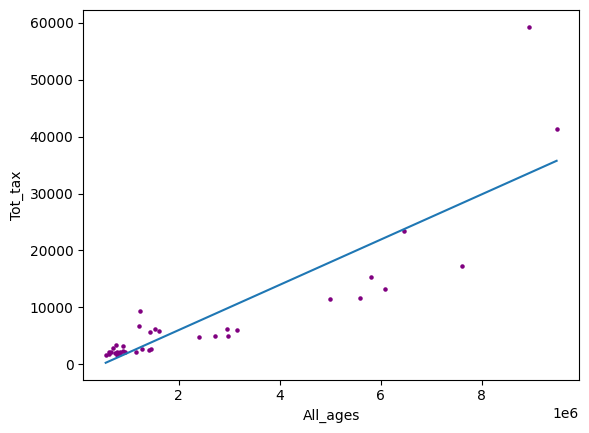

In [8]:
import sys
import matplotlib # pip install matplotlib
import matplotlib.pyplot as plt

# Convert to Pandas
Pop = Cond_Pop.toPandas()
Inc = Cond_Inc.toPandas()
Sta = Statements.toPandas()
Dat = Cast_Data.toPandas()

# Visualise data 
ax = Dat.plot.scatter(x='All_ages',y='Tot_tax',s=5,c='purple',grid=True)

# Create line of best fit
z = np.polyfit(x=Dat.loc[:,'All_ages'],y=Dat.loc[:,'Tot_tax'],deg=1)
p = np.poly1d(z)
Dat['Trendline'] = p(Dat.loc[:,'All_ages'])

Dat.set_index('All_ages',inplace=True)
Dat.Trendline.sort_index(ascending=False).plot(ax=ax)

cat_var = []

# Create category
for All_ages in Dat.iterrows():
    if All_ages < 200000:
        cat_var.append('Lower')
    elif All_ages > 200000 and i < 400000:
        cat_var.append('Lower middle')
    elif All_ages > 400000 and i < 800000:
        cat_var.append('Upper middle')
    else:
        cat_var.append('Upper')


# Create the groups seen in graph
colours = {'Lower': 'red', 'Lower middle': 'pink', 'Upper middle': 'purple', 'Upper': 'blue'}
colour_list = [colours[group] for group in cat_var]

gro_ax = Dat.plot.scatter('All_ages','Tot_tax',c=colour_list,grid=True)

In [ ]:
# Imports
#from sklearn.ensemble import RandomForestClassifier # pip3 install -U scikit-learn scipy matplotlib
from pyspark.ml.classification import RandomForestClassifier # pip install setuptools
from pyspark.ml.evaluation import RegressionEvaluator 
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

#Cast_Data.printSchema()

# Split data
train_data, test_data = Cast_Data.randomSplit([0.8, 0.2])

# Create classifier
rf = RandomForestClassifier()

# Create target data 
#Cast_Data.summary().show()

Cast_Data.show()

# Create model
#model = rf.fit(train_data)


+--------+-------+-----+------+-------------+----------+------------+-----------+--------+----------+-----------+--------+----------+-------+---+---------+--------------------+
|All ages|Num_ind| Mean|Median|Other_num_ind|Other_mean|Other_median|Tot_num_ind|Tot_mean|Tot_median|Tax_num_ind|Tax_mean|Tax_median|Tot_tax| id|     Code|                Area|
+--------+-------+-----+------+-------------+----------+------------+-----------+--------+----------+-----------+--------+----------+-------+---+---------+--------------------+
| 2711380|    929|30200| 24700|          508|      3840|          31|       1230|   31500|     24900|       1230|    4110|      2230|   5060|  1|E12000001|          North East|
| 1153212|    396|30500| 25000|          197|      3800|          29|        508|   31700|     25200|        508|    4120|      2290|   2090|  2|E11000007|         Tyne & Wear|
| 7600126|   2690|32000| 25000|         1410|      5930|          43|       3490|   34000|     25700|       3490|  